My kaggle name is Desmond Doran and my username is desmond_doran kaggle score

Titanic kaggle score:0.79032

Spam kaggle score   :0.75106

In [476]:
import os
#os.chdir should not need to be changed

import random as random
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

from csv import DictReader
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer

# You may want to install "gprof2dot"
import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin

import pydot

eps = 1e-5  # a small number

%run ./util.ipynb

class DecisionTree:
    
    def __init__(self,params={'max_depth':3,"feature_info":None}, feature_labels=None,tests=None):
        '''
        params={'max_depth':3,'m':-1}
        m=-1 if we want to split on every feature which is not silenced.
        '''
        
        self.max_depth = params["max_depth"]
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.branch_idx, self.branch_test = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.feature_info=params["feature_info"]
        self.m=params["m"]
        self.params=params
        
        self.tests=tests# not implemented
        
    def information_gain(self, X, y,idx ,test):
        # TODO implement information gain function
        
        ebefore=calculate_entropy(y)
        X0, y0, X1, y1=self.split(X,y,idx,test)
        eafter=(calculate_entropy(y0)*y0.shape[0]/y.shape[0]+calculate_entropy(y1)*y1.shape[0]/y.shape[0])
        
        return ebefore-eafter#iafter is actually enrtopy after 

    def gini_impurity(self, X, y,idx ,test):
        # TODO implement gini_impurity function
        
        probmisbefore=calculate_gini(y)
        
        X0, y0, X1, y1=self.split(X,y,idx,test)
        
        probmisafter=calculate_gini(y1)*y1.shape[0]/y.shape[0]+calculate_gini(y1)*y1.shape[0]/y.shape[0]
        return probmisafter

    def split(self, X, y, idx, test):
        #we take feature corresponding to idx
        X0, idx0, X1, idx1 = self.split_test(X, idx, test)
        #idx0 is the indices of X[:,idx] which are less than the threshold
        #X0 is the values of X[:,idx] which are less than the threshold
        
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, test): 
        ###idx0 = np.where(1*np.apply_along_axis(test["func"],1,X))[0]
        ####indices where this is true, np.where() returns tuple, the indices are the first entry.
        ###idx1 = np.where(1- np.apply_along_axis(test["func"],1,X))[0]
        
        
        idx0 = (X[:,test["feature_id"]]==test["tresh"] 
                if test["test_type"]=="eq" 
                else X[:,test["feature_id"]]<=test["tresh"] )
        #indices where this is true, np.where() returns tuple, the indices are the first entry.
        
        idx1 = (X[:,test["feature_id"]]!=test["tresh"] 
                if test["test_type"]=="eq" 
                else X[:,test["feature_id"]]>test["tresh"] )
        
        
        X0, X1 = X[idx0, :], X[idx1, :]
        #idx0 is the indices of X[:, idx] which are less than the threshold.
        #X0 is the values  of X[:, idx] which are less than the threshold. (order maintained)
        return X0, idx0, X1, idx1 

    def fit(self, X, y):
        if self.max_depth > 0:
            # could add another stopping condition like only split 
            # if however many are left in node or if these is enough entropy.
            
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            
            #if self.tests=None
            
            split_feature_inds=[i for i in range(len(self.feature_info)) if not self.feature_info[i]['silence']]
            if self.m!=-1 and self.m<len(split_feature_inds):
                random.shuffle(split_feature_inds)
                split_feature_inds=split_feature_inds[:self.m]
            
            tests=[]
            for i in range(X.shape[1]):
                if self.feature_info[i]['silence']==True or i not in split_feature_inds :#elegantish hack!
                    tests.append([])
                    continue
                    
                if self.feature_info[i]["type"]==0:#catagorical
                    tests.append(createCatagoricalTests(X,y,i))
                    
                else:#quantitative
                    tests.append(createQuantitativeTests(X,y,i))
            
            argmaxgains=[]
            maxgain=0
                
                
            for i in split_feature_inds:
                    
                    
                cgains=[self.information_gain(X, y,i, test) for test in tests[i]]
                
                gains.append(cgains)
                
                if len(tests[i])==0:
                    continue
                if max(cgains)>maxgain:
                    maxgain=max(cgains)
                    argmaxgains=[]
                    
                if max(cgains)>=maxgain:
                    for j in range(len(cgains)):
                        if cgains[j]==maxgain:
                            argmaxgains.append([i,j])

            if len(argmaxgains)==0:# ran out of features to split on!
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
                return self
                
            X0, y0, X1, y1 = self.split(X, y, argmaxgains[0][0], tests[argmaxgains[0][0]][argmaxgains[0][1]])
            
            if X0.size > 0 and X1.size > 0:
                self.branch_idx=argmaxgains[0][0]
                self.branch_test= tests[argmaxgains[0][0]][argmaxgains[0][1]]
                
                next_params=self.params.copy()
                next_params['max_depth']-=1
                self.left = DecisionTree(params=next_params, feature_labels=self.features)#test true
                self.left.fit(X0, y0)
                
                self.right = DecisionTree(params=next_params, feature_labels=self.features)#test false
                self.right.fit(X1, y1)
            else:#make into leaf
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
                
        else:#make it into a leaf node
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, self.branch_idx, self.branch_test)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat
        
    def test(self, X,y):
        #unregularised loss, regularised loss, accuracy.
        #Note I`m not using loss here so percentage error is a placeholder
        unregl=1-np.mean(np.round(self.predict(X))==y)
        regl=1-np.mean(np.round(self.predict(X))==y)
        acc=np.mean(np.round(self.predict(X))==y)
        return [unregl,regl,acc]
        


class BaggedTrees(BaseEstimator, ClassifierMixin):
    '''
    Disclaimer I use B and n in the reverse way they are used in question
    '''
    
    def __init__(self, params={"n":200,"feature_info":None}):
        '''
        params={'max_depth':3,"n":200}
        '''
        if params is None:
            params = {}
        self.params = params
        self.feature_info=params["feature_info"]
        self.n = params["n"]
        self.decision_trees = [
            DecisionTree(params=self.params)
            for i in range(self.n)
        ]
    
    def fit(self, X, y):
        for dt in self.decision_trees:
            inds=bootStrapSampleInds(X.shape[0],self.params['B'])
            dt.fit(X[inds],y[inds])
    
        return self

    def predict(self, X):
        outs=[]
        for dt in self.decision_trees:
            outs.append(dt.predict(X))
        outs=np.array(outs).T
        preds=[]
        for i in range(outs.shape[0]):
            preds.append(stats.mode(outs[i]).mode[0])
        
        preds=np.array(preds)
        return preds
    
    def test(self, X,y):
        #unregularised loss, regularised loss, accuracy.
        #Note I`m not using loss here so percentage error is a placeholder
        unregl=1-np.mean(np.round(self.predict(X))==y)
        regl=1-np.mean(np.round(self.predict(X))==y)
        acc=np.mean(np.round(self.predict(X))==y)
        return [unregl,regl,acc]


class RandomForest(BaggedTrees):
    '''
    Disclaimer I use B and n in the reverse way they are used in question
    '''
    #note that fit and predict are inherited from BaggedTrees
    
    def __init__(self, params={"n":1,"m":1,"feature_info":None}):
        '''
        params={'max_depth':3,'n':1,'m':1}
        params - B - Bootstrap size
               - m - How many features we want each subtree to use.
               - n - How many subtrees you want 
        '''
        if params is None:
            params = {}
        self.params = params
        self.feature_info=params["feature_info"]
        self.n = params["n"]
        n=self.n
        self.m = params["m"]
        m=self.m
        
        
        self.decision_trees = [
            DecisionTree(params=self.params)
            for i in range(self.n)
        ]
        
        '''I had the wrong idea here :(
        working_feature_inds=[]#indices of features which we will use in at least some sub tree
        for i in range(len(self.feature_info)):
            if self.feature_info[i]['silence']:#feature silenced in whole random forest
                continue

            working_feature_inds.append(i)
        modified_feature_infos=[]
        
        for i in range(n):# silence some of the variables
            random.shuffle(working_feature_inds)
            temp=[dict(fi) for fi in feature_info]
            for j in range(m,len(working_feature_inds)):                
                temp[working_feature_inds[j]]['silence']=True
            modified_feature_infos.append(temp)
            
            
        
        sub_tree_params=[self.params.copy() for i in range(self.n)]
        for i in range(self.n):
            sub_tree_params[i]['feature_info']=modified_feature_infos[i]
            
            
        
        '''
        
        

def bootStrapSampleInds(n,B):
        inds=np.array([random.randint(0,n-1) for i in range(B)])
        return inds
    
    
class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO implement function
        return self

    def predict(self, X):
        # TODO implement function
        pass



def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):#I am not using this
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():#iterates through terms in order of multiplicity
            if term[0] == b'-1':#empty
                continue
            if term[-1] <= min_freq:
                break
                
            #the term occurs more than min_freq and is not the empty term
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)



In [509]:
# Load titanic data
path_train = 'titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=str)
path_test = 'titanic_testing_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=str)
y = data[1:, 0]  # label = survived
class_names = ["Died", "Survived"]

labeled_idx = np.where(y != "")[0]#edge case only happens once, these are all th valid indices
y = np.array(y[labeled_idx], dtype=np.int)
print("\n\nPart (b): preprocessing the titanic dataset")
X,feature_type = preprocess_titanic(data[1:, 1:])
X = X[labeled_idx, :]
Z,feature_type = preprocess_titanic(test_data[1:, :])
assert X.shape[1] == Z.shape[1]
features = X.shape[1]
print("done")



Part (b): preprocessing the titanic dataset
done


C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [510]:
feature_names=['pclass', 'sex', 'age', 'sibsp', 'parch','ticket contains letters','fare','cabin listed',
                  'cabin letter','cabin number','embarked']
feature_info=[]
for i in range(len(feature_names)):
    feature_info.append({"type":feature_type[i],"name":feature_names[i],"original_index":i,'silence':False})
    

In [511]:
titanic_data={'X':X,'y':y,'feature_info':feature_info.copy(),"X_test":Z}

In [503]:
features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
    "height", "featured", "differ", "width", "other", "energy", "business", "message",
    "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
    "ampersand"
]
assert len(features) == 32

# Load spam data
path_train = 'spam_data.mat'
data = scipy.io.loadmat(path_train)

X = data['training_data']
indices=[i for i in range(X.shape[0])]
y = np.squeeze(data['training_labels'])
random.seed(a=1)
random.shuffle(indices)
X=X[indices]
y=y[indices]
Z = data['test_data']
class_names = ["Ham", "Spam"]

In [504]:
feature_names=features
feature_info=[]
for i in range(len(feature_names)):
    feature_info.append({"type":1,"name":feature_names[i],"original_index":i,'silence':False})
    

In [505]:
spam_data={'X':X,'y':y,'feature_info':feature_info.copy(),"X_test":Z}

In [506]:
titanic_dt_params={"feature_info":titanic_data['feature_info'],'B':-1,'max_depth':3,'m':-1,'n':-1}
titanic_rf_params={"feature_info":titanic_data['feature_info'],'B':300,'max_depth':6,'m':6,'n':200}
spam_dt_params={"feature_info":spam_data['feature_info'],'B':-1,'max_depth':3,'m':-1,'n':-1}
spam_rf_params={"feature_info":spam_data['feature_info'],'B':200,'max_depth':3,'m':3,'n':25}
rf_silence_list=[1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1]# found by forward subset selection
for i in range(len(rf_silence_list)):
    spam_rf_params['feature_info'][i]['silence']=(rf_silence_list[i]==0)

In [406]:
#titanic_dt_params,titanic_rf_params,spam_dt_params,spam_rf_params
random.seed(1)
titanic_dt=DecisionTree(titanic_dt_params)
titanic_dt_result=cross_validate(titanic_dt,titanic_data["X"],titanic_data["y"],3,titanic_dt_params)

titanic_rf=RandomForest(titanic_rf_params)# note this takes a while to run, could set folds to 2 to get similar result
titanic_rf_result=cross_validate(titanic_rf,titanic_data["X"],titanic_data["y"],3,titanic_rf_params)

spam_dt=DecisionTree(spam_dt_params)
spam_dt_result=cross_validate(spam_dt,spam_data["X"],spam_data["y"],3,spam_dt_params)

spam_rf=RandomForest(spam_rf_params)
spam_rf_result=cross_validate(spam_rf,spam_data["X"],spam_data["y"],3,spam_rf_params)

In [407]:
print("Titanic results:")
print("Decision Tree:")
print("Training accuracy: "+str(titanic_dt_result[2]))
print("Validation accuracy: "+str(titanic_dt_result[5]))
print()
print("Random Forest:")
print("Training accuracy: "+str(titanic_rf_result[2]))
print("Validation accuracy: "+str(titanic_rf_result[5]))
print()
print()
print("Spam results:")
print("Decision Tree:")
print("Training accuracy: "+str(spam_dt_result[2]))
print("Validation accuracy: "+str(spam_dt_result[5]))
print()
print("Random Forest:")
print("Training accuracy: "+str(spam_rf_result[2]))
print("Validation accuracy: "+str(spam_rf_result[5]))
print()

Titanic results:
Decision Tree:
Training accuracy: 0.8078078078078078
Validation accuracy: 0.7887887887887888

Random Forest:
Training accuracy: 0.8453453453453453
Validation accuracy: 0.7997997997997999


Spam results:
Decision Tree:
Training accuracy: 0.7952436194895592
Validation accuracy: 0.7946635730858468

Random Forest:
Training accuracy: 0.7953402938901779
Validation accuracy: 0.7927300850734724



In [517]:
#kaggle - spam results may differ (or not) as I had to ammend things to make titanic work and ran out of kaggle 
# entry allowances.
random.seed(a=1)
kaggle_titanic_rf=RandomForest(titanic_rf_params)
kaggle_spam_dt=DecisionTree(spam_dt_params)
kaggle_titanic_rf.fit(titanic_data["X"],titanic_data["y"])
kaggle_spam_dt.fit(spam_data["X"],spam_data["y"])
print('Done')

Done


In [518]:

kaggle_titanic_predictions = kaggle_titanic_rf.predict(titanic_data["X_test"])
kaggle_spam_predictions    = kaggle_spam_dt.predict(spam_data["X_test"])

In [319]:
from codegiven import save_csv#code given to us

In [520]:
save_csv.results_to_csv((np.round(kaggle_titanic_predictions)==1).astype(int))

In [348]:
save_csv.results_to_csv((np.round(kaggle_spam_predictions)==1).astype(int))

In [275]:
def testPoint(test,data_point):
    if test["test_type"]=="eq":
        
        return data_point[test['feature_id']]==test['tresh']
    elif  test["test_type"]=="leq":
        return data_point[test['feature_id']]<=test['tresh']    
    else:
        assert False
    
def traceTreePath(tree, data_point,depth,labels=["ham","spam"]):
    if tree.left is None:#if leaf
        return "Then this is "+labels[tree.pred]+"\n"
    else:#if branch
        depth+=1
        if testPoint(tree.branch_test,data_point):#left - true
            det=""
            det+=tree.feature_info[tree.branch_test["feature_id"]]["name"]
            
            if tree.branch_test["test_type"]=="eq":
                det+="=="
            else:
                det+="<="
                
            det+=str(tree.branch_test["tresh"])
                        
            return det+"\n"+traceTreePath(tree.left, data_point,depth,labels=labels)
        else:#right - false
            
            det=""
            det+=tree.feature_info[tree.branch_test["feature_id"]]["name"]
            
            if tree.branch_test["test_type"]=="eq":
                det+="!="
            else:
                det+=">"
                
            det+=str(tree.branch_test["tresh"])
                        
            return det+"\n"+traceTreePath(tree.right, data_point,depth,labels=labels)
 
    
def treeDescription(trees):
    
    next_trees=[]
    dets=[]
    end=True
    for i in range(len(trees)):
        det=""#detail of tree split test
        if trees[i].left is not None:
            det+=trees[i].feature_info[trees[i].branch_test["feature_id"]]["name"]
            
            if trees[i].branch_test["test_type"]=="eq":
                det+="=="
            else:
                det+="<="
                
            det+=str(trees[i].branch_test["tresh"])
            
            end=False
            next_trees.append(trees[i].left)
            next_trees.append(trees[i].right)
        else:
            next_trees.append(None)
            next_trees.append(None)
            det=str(trees[i].pred)
        dets.append(det)
            
    if end:
        return [],[dets]
    next_level=treeDescription(next_trees)
    return [trees]+next_level[0],[dets]+next_level[1]
    
               

In [282]:

'''
I have written out this tree on a sheet of paper
sex==0 -is female


'''
treeDescription([titanic_dt])

([[<__main__.DecisionTree at 0x1bd572df388>],
 [['sex==0.0'],
  ['pclass==0.0', 'cabin listed==0.0'],
  ['fare<=23.35', 'fare<=21.0', 'fare<=387.6646', 'fare<=7.74585'],
  ['1', '0', '1', '1', '0', '1', '0', '0']])

In [309]:
print(traceTreePath(spam_dt,spam_data['X'][0],0))
print(traceTreePath(spam_dt,spam_data["X"][1],0))

exclamation<=0.0
meter<=0.0
parenthesis<=0.0
Then this is ham

exclamation>0.0
meter<=0.0
ampersand<=0.0
Then this is spam



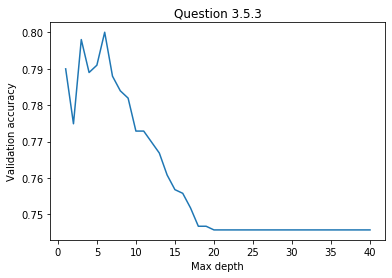

In [333]:
titanic_plot_params=[{"feature_info":titanic_data['feature_info']
                      ,'B':-1,'max_depth':i,'m':-1,'n':-1} for i in range(1,41)]
val_accs=[]
for params in titanic_plot_params:
    #Note I am doing 5-fold cross-validation this does 5 80/20 splits for iteration. 
    #This is made random at the very start
    val_accs.append(cross_validate(DecisionTree(params),titanic_data['X'],titanic_data['y'],5,params)[5])

plt.xlabel("Max depth")
plt.ylabel("Validation accuracy")
plt.title("Question 3.5.3")
plt.plot([i for i in range(1,len(titanic_plot_params)+1)],val_accs,"")
plt.savefig("Q353")

Below is code I used for validation

In [69]:
'''
titanic_data['feature_info']['silence'] is really the only variable we might want to change in feature info

max_depth is how many splits there should be on our tree

For random forest
m is how many features we should include in random forest
B is how big each bootstrap sample should be
n is how how many trees we should have

Recommended values
Random forest should stabailise at n=200 (Boosting 1000)

For classification :
m should be square root the number of features
Also minimum node size is 1 (should not split if a node contains fewer than 1 element)

For regression :
m should be number of features divided by 3
Also minimum node size is 5 (should not split if a node contains fewer than 5 elements)


Chosen variables:
For random forest titanic
m=6
max_depth=6
B=600 (bigger may be better)
n=500

'''
#not doing feature subset seleciton for titanic data.
ms=[6]
max_depths=[6]

#ms=[3,5]
#max_depths=[4,6]
Bs=[600]
n=150
random.seed(1)
rf_summary=np.array([[[
    {'B':B,'max_depth':max_depth,'m':m,'n':n}
       for m in ms]
        for max_depth in max_depths]
        for B in Bs])
rf_params_array=np.array([[[
    {"feature_info":titanic_data['feature_info'],'B':B,'max_depth':max_depth,'m':m,'n':n}
       for m in ms]
        for max_depth in max_depths]
        for B in Bs])
rf_models=np.array([[[
    RandomForest(params={"feature_info":titanic_data['feature_info'],'B':B,'max_depth':max_depth,'m':m,'n':n})
       for m in ms]
        for max_depth in max_depths]
        for B in Bs])

rf_max_accs,rf_max_params,rf_param_results,_=cross_validate_report(rf_models,titanic_data["X"],titanic_data['y'],3,
                                                     rf_params_array,give_print=True)


With parameters : 
{'feature_info': [{'type': 0, 'name': 'pclass', 'original_index': 0, 'silence': False}, {'type': 0, 'name': 'sex', 'original_index': 1, 'silence': False}, {'type': 1, 'name': 'age', 'original_index': 2, 'silence': False}, {'type': 1, 'name': 'sibsp', 'original_index': 3, 'silence': False}, {'type': 1, 'name': 'parch', 'original_index': 4, 'silence': False}, {'type': 0, 'name': 'ticket contains letters', 'original_index': 5, 'silence': False}, {'type': 1, 'name': 'fare', 'original_index': 6, 'silence': False}, {'type': 0, 'name': 'cabin listed', 'original_index': 7, 'silence': False}, {'type': 1, 'name': 'cabin letter', 'original_index': 8, 'silence': False}, {'type': 1, 'name': 'cabin number', 'original_index': 9, 'silence': False}, {'type': 0, 'name': 'embarked', 'original_index': 10, 'silence': False}], 'B': 400, 'max_depth': 6, 'm': 6, 'n': 150}
Training loss is : 0.15215215215215216
Training Accuracy is : 0.8478478478478478
Cross validation loss is : 0.202202202

In [70]:
print(rf_param_results[:,:,:,5])
print(rf_summary)

[[[0.7977978]
  [0.7997998]]

 [[0.8038038]
  [0.7997998]]]
[[[{'B': 400, 'max_depth': 6, 'm': 6, 'n': 150}]
  [{'B': 400, 'max_depth': 8, 'm': 6, 'n': 150}]]

 [[{'B': 600, 'max_depth': 6, 'm': 6, 'n': 150}]
  [{'B': 600, 'max_depth': 8, 'm': 6, 'n': 150}]]]


In [80]:
#max_depth=3 is best!
ms=[-1]
max_depths=[1,2,3,4,5,6,8,12]
Bs=[-1]
n=200
random.seed(1)
dt_summary=np.array([[[
    {'B':B,'max_depth':max_depth,'m':m,'n':n}
       for m in ms]
        for max_depth in max_depths]
        for B in Bs])
dt_params_array=np.array([[[
    {"feature_info":titanic_data['feature_info'],'B':B,'max_depth':max_depth,'m':m,'n':n}
       for m in ms]
        for max_depth in max_depths]
        for B in Bs])
dt_models=np.array([[[
    DecisionTree(params={"feature_info":titanic_data['feature_info'],'B':B,'max_depth':max_depth,'m':m,'n':n})
       for m in ms]
        for max_depth in max_depths]
        for B in Bs])

dt_max_accs,dt_max_params,dt_param_results,_=cross_validate_report(dt_models,titanic_data["X"],titanic_data['y'],10,
                                                     dt_params_array,give_print=True)


With parameters : 
{'feature_info': [{'type': 0, 'name': 'pclass', 'original_index': 0, 'silence': False}, {'type': 0, 'name': 'sex', 'original_index': 1, 'silence': False}, {'type': 1, 'name': 'age', 'original_index': 2, 'silence': False}, {'type': 1, 'name': 'sibsp', 'original_index': 3, 'silence': False}, {'type': 1, 'name': 'parch', 'original_index': 4, 'silence': False}, {'type': 0, 'name': 'ticket contains letters', 'original_index': 5, 'silence': False}, {'type': 1, 'name': 'fare', 'original_index': 6, 'silence': False}, {'type': 0, 'name': 'cabin listed', 'original_index': 7, 'silence': False}, {'type': 1, 'name': 'cabin letter', 'original_index': 8, 'silence': False}, {'type': 1, 'name': 'cabin number', 'original_index': 9, 'silence': False}, {'type': 0, 'name': 'embarked', 'original_index': 10, 'silence': False}], 'B': -1, 'max_depth': 1, 'm': -1, 'n': 200}
Training loss is : 0.2112222222222222
Training Accuracy is : 0.7887777777777778
Cross validation loss is : 0.2111111111

In [98]:
stepwise_selection(spam_data['X'][:1500],spam_data['y'][:1500],spam_dt_params,steps=4)

C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:239: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:240: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0.7313333333333333
0.7246666666666667
0.7226666666666667
0.7453333333333333
0.7213333333333333
0.7273333333333333
0.7346666666666666
0.7273333333333333
0.7146666666666667
0.726
0.726
0.7173333333333334
0.714
0.7146666666666667
0.7166666666666667
0.7126666666666667
0.7146666666666667
0.7146666666666667
0.7146666666666667
0.7146666666666667
0.7146666666666667
0.7146666666666667
0.7146666666666667
0.7113333333333333
0.7146666666666667
0.7146666666666667
0.7200000000000001
0.714
0.7706666666666667
0.714
0.7159999999999999
0.714
0.7799999999999999
0.7746666666666666
0.774
0.7666666666666666
0.7706666666666667
0.7706666666666667
0.7753333333333333
0.7706666666666667
0.7706666666666667
0.7746666666666666
0.7753333333333333
0.7706666666666667
0.7693333333333333
0.7680000000000001
0.7693333333333333
0.7806666666666667
0.7826666666666666
0.7706666666666667
0.7726666666666667
0.7866666666666667
0.7706666666666667
0.7719999999999999
0.7706666666666667
0.7706666666666667
0.7733333333333334
0.774666

[[0.7706666666666667,
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0]],
 [0.7919999999999999,
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1]],
 [0.8039999999999999,
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1]],
 [0.8133333333333334,
  [1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1]]]

In [106]:
dt_silence_list=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1]
for i in range(len(silence_list)):
    spam_dt_params['feature_info'][i]['silence']=(silence_list[i]==0)

In [110]:
spam_pre_rf_params={"feature_info":spam_data['feature_info'],'B':-1,'max_depth':3,'m':2,'n':-1}
out=stepwise_selection(spam_data['X'][1500:2000],spam_data['y'][1500:2000],
                       spam_pre_rf_params,steps=2,starting_list=dt_silence_list)
#this is decision tree but with random features

C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:239: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:240: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0.7248995983935743
0.7329317269076304
0.7751004016064256
0.7269076305220884
0.7650602409638555
0.7670682730923696
0.7409638554216867
0.7710843373493975
0.7771084337349398
0.7630522088353414
0.7670682730923696
0.7630522088353414
0.7670682730923696
0.7550200803212851
0.7409638554216867
0.7429718875502008
0.7389558232931727
0.7650602409638555
0.7228915662650602
0.7530120481927711
0.7429718875502008
0.7630522088353414
0.7590361445783133
0.7630522088353414
0.7530120481927711
0.7610441767068273
0.7449799196787149
0.7630522088353414
0.751004016064257
0.7449799196787149
0.7650602409638555
0.7309236947791166
0.7650602409638555
0.748995983935743
0.7248995983935743
0.751004016064257
0.7650602409638555
0.7570281124497992
0.7550200803212852
0.7269076305220884
0.7349397590361445
0.7630522088353414
0.7309236947791166
0.7610441767068273
0.7570281124497992
0.7389558232931727
0.7469879518072289
0.748995983935743
0.7269076305220884
0.7329317269076304
0.7751004016064257
0.7550200803212852
0.73493975903614

In [112]:
spam_pre_rf_params={"feature_info":spam_data['feature_info'],'B':-1,'max_depth':3,'m':2,'n':-1}
out1=stepwise_selection(spam_data['X'][2000:3500],spam_data['y'][2000:3500],
                       spam_pre_rf_params,steps=2,starting_list=out[1][1])
#this is decision tree but with random features

C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:239: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:240: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\desco\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0.7826666666666666
0.7793333333333333
0.7726666666666667
0.7600000000000001
0.7713333333333333
0.7853333333333333
0.742
0.7753333333333333
0.7719999999999999
0.7799999999999999
0.7693333333333333
0.7399999999999999
0.7506666666666666
0.7413333333333334
0.7333333333333334
0.7646666666666667
0.782
0.738
0.7520000000000001
0.7360000000000001
0.7393333333333333
0.738
0.7273333333333335
0.7766666666666667
0.786
0.7846666666666667
0.7506666666666666
0.7213333333333334
0.7166666666666668
0.7413333333333334
0.7586666666666666
0.7466666666666667
0.7433333333333333
0.7333333333333334
0.7506666666666666
0.7426666666666666
0.742
0.7666666666666666
0.7159999999999999
0.7460000000000001
0.7073333333333333
0.7553333333333333
0.77
0.7746666666666666
0.7080000000000001
0.7653333333333334
0.7486666666666668
0.7713333333333333
0.746
0.7366666666666667
0.7646666666666667


In [501]:
titanic_dt_params={"feature_info":titanic_data['feature_info'],'B':-1,'max_depth':3,'m':-1,'n':-1}
titanic_rf_params={"feature_info":titanic_data['feature_info'],'B':600,'max_depth':6,'m':6,'n':500}
spam_dt_params={"feature_info":spam_data['feature_info'],'B':-1,'max_depth':3,'m':-1,'n':-1}
spam_rf_params={"feature_info":spam_data['feature_info'],'B':200,'max_depth':3,'m':3,'n':100}
rf_silence_list=[1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1]# found by forward subset selection
for i in range(len(rf_silence_list)):
    spam_rf_params['feature_info'][i]['silence']=(rf_silence_list[i]==0)
    
#titanic_dt_params,titanic_rf_params,spam_dt_params,spam_rf_params
random.seed(1)
titanic_dt=DecisionTree(titanic_dt_params)
titanic_dt_result=cross_validate(titanic_dt,titanic_data["X"],titanic_data["y"],3,titanic_dt_params)

titanic_rf=RandomForest(titanic_rf_params)# note this takes a while to run, could set folds to 2 to get similar result
titanic_rf_result=cross_validate(titanic_rf,titanic_data["X"],titanic_data["y"],3,titanic_rf_params)

spam_dt=DecisionTree(spam_dt_params)
spam_dt_result=cross_validate(spam_dt,spam_data["X"],spam_data["y"],3,spam_dt_params)

spam_rf=RandomForest(spam_rf_params)
spam_rf_result=cross_validate(spam_rf,spam_data["X"],spam_data["y"],3,spam_rf_params)

print("Titanic results:")
print("Decision Tree:")
print("Training accuracy: "+str(titanic_dt_result[2]))
print("Validation accuracy: "+str(titanic_dt_result[5]))
print()
print("Random Forest:")
print("Training accuracy: "+str(titanic_rf_result[2]))
print("Validation accuracy: "+str(titanic_rf_result[5]))
print()
print()
print("Spam results:")
print("Decision Tree:")
print("Training accuracy: "+str(spam_dt_result[2]))
print("Validation accuracy: "+str(spam_dt_result[5]))
print()
print("Random Forest:")
print("Training accuracy: "+str(spam_rf_result[2]))
print("Validation accuracy: "+str(spam_rf_result[5]))
print()

KeyboardInterrupt: 